# 4.4 Stop-Loss Analysis

**Problem**: Non-monotonic stop-loss effect is suspicious:
- 20% SL: -9% return
- 30% SL: +305% return
- 50% SL: +71% return

**Analyses**:
1. Fine-grained SL sweep (1% increments around 30%)
2. Trade-level analysis - which trades are affected?
3. Time-period stability - does 30% SL work across all periods?
4. Outlier analysis - is this driven by 1-2 trades?
5. Per-symbol breakdown - which stocks cause the effect?

In [1]:
import sys
sys.path.insert(0, '.')

import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from dataclasses import replace

logging.basicConfig(level=logging.WARNING, format='%(levelname)s - %(message)s')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

In [3]:
from trading.bt_runner import run_backtest
from trading.config import TradingConfig, StrategyConfig, DEFAULT_CONFIG

MODEL_PATH = Path('data/model_robust_optimized.pt')
DATA_DIR = Path('data')
START_DATE = '2024-10-22'
END_DATE = '2025-12-18'
INITIAL_CASH = 100_000

## 1. Fine-Grained Stop-Loss Sweep

In [ ]:
# Test stop-losses from 5% to 100% in 5% increments
stop_loss_levels = [0.05, 0.10, 0.15, 0.20, 0.25, 0.28, 0.30, 0.32, 0.35, 0.40, 0.50, 0.60, 0.70, 0.80, 1.0, None]

fine_sl_results = []

print("FINE-GRAINED STOP-LOSS SWEEP")
print("=" * 70)

for sl in stop_loss_levels:
    sl_label = f"{sl*100:.0f}%" if sl else "None"
    print(f"Testing stop-loss = {sl_label}...", end=" ")
    
    strategy_cfg = replace(DEFAULT_CONFIG.strategy, stop_loss_pct=sl)
    config = replace(DEFAULT_CONFIG, strategy=strategy_cfg)
    
    result = run_backtest(
        config=config,
        model_path=MODEL_PATH,
        data_dir=DATA_DIR,
        start_date=START_DATE,
        end_date=END_DATE,
        initial_cash=INITIAL_CASH,
        use_dd_scaling=False,
        use_confidence=False,
        news_only=True,
    )
    
    fine_sl_results.append({
        'stop_loss': sl,
        'stop_loss_label': sl_label,
        'return': result.total_return,
        'sharpe': result.sharpe_ratio,
        'max_dd': result.max_drawdown,
        'n_trades': result.n_trades,
    })
    
    print(f"Return={result.total_return*100:+.1f}%, Sharpe={result.sharpe_ratio:.2f}")

print("=" * 70)

FINE-GRAINED STOP-LOSS SWEEP
Testing stop-loss = 5%... Return=-69.3%, Sharpe=-7.84
Testing stop-loss = 10%... Return=-81.3%, Sharpe=-28.43
Testing stop-loss = 15%... Return=-86.0%, Sharpe=-10.58
Testing stop-loss = 20%... Return=-26.3%, Sharpe=0.18
Testing stop-loss = 25%... Return=+11.3%, Sharpe=0.49
Testing stop-loss = 28%... Return=+10.5%, Sharpe=0.45
Testing stop-loss = 30%... 

In [ ]:
fine_df = pd.DataFrame(fine_sl_results)
fine_df['return_pct'] = fine_df['return'] * 100
fine_df['max_dd_pct'] = fine_df['max_dd'] * 100

print("\nFine-Grained Results:")
print(fine_df[['stop_loss_label', 'return_pct', 'sharpe', 'max_dd_pct', 'n_trades']].to_string(index=False))

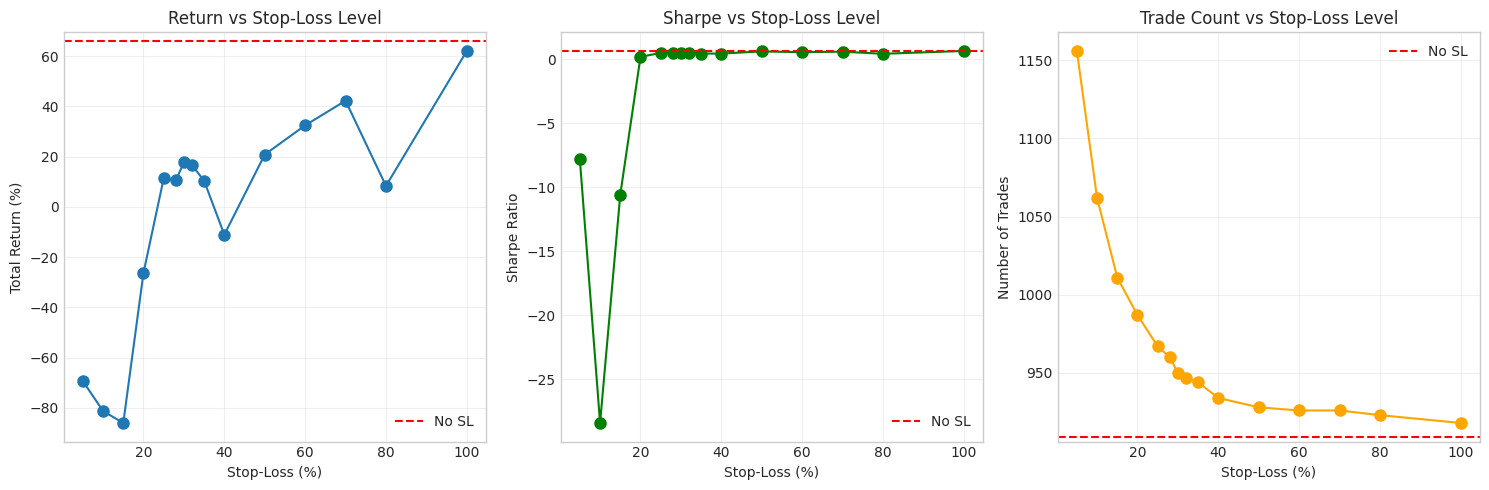

In [14]:
# Plot stop-loss vs return
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Filter out None for plotting
plot_df = fine_df[fine_df['stop_loss'].notna()].copy()
plot_df['sl_pct'] = plot_df['stop_loss'] * 100

ax = axes[0]
ax.plot(plot_df['sl_pct'], plot_df['return_pct'], 'o-', markersize=8)
ax.axhline(fine_df[fine_df['stop_loss'].isna()]['return_pct'].values[0], 
           color='red', linestyle='--', label='No SL')
ax.set_xlabel('Stop-Loss (%)')
ax.set_ylabel('Total Return (%)')
ax.set_title('Return vs Stop-Loss Level')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(plot_df['sl_pct'], plot_df['sharpe'], 'o-', markersize=8, color='green')
ax.axhline(fine_df[fine_df['stop_loss'].isna()]['sharpe'].values[0], 
           color='red', linestyle='--', label='No SL')
ax.set_xlabel('Stop-Loss (%)')
ax.set_ylabel('Sharpe Ratio')
ax.set_title('Sharpe vs Stop-Loss Level')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[2]
ax.plot(plot_df['sl_pct'], plot_df['n_trades'], 'o-', markersize=8, color='orange')
ax.axhline(fine_df[fine_df['stop_loss'].isna()]['n_trades'].values[0], 
           color='red', linestyle='--', label='No SL')
ax.set_xlabel('Stop-Loss (%)')
ax.set_ylabel('Number of Trades')
ax.set_title('Trade Count vs Stop-Loss Level')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Trade-Level Analysis

Get individual trade returns to understand what's happening.

In [ ]:
# Load the ML dataset to analyze returns
ml_df = pd.read_parquet(DATA_DIR / 'ml_dataset.pqt')
ml_df['date'] = pd.to_datetime(ml_df['feature_date'])

# Filter to test period
test_df = ml_df[
    (ml_df['date'] >= START_DATE) & 
    (ml_df['date'] <= END_DATE)
].copy()

# target_return is log return
test_df['log_return'] = test_df['target_return']
test_df['simple_return'] = np.exp(test_df['log_return']) - 1

print(f"Test period: {test_df['date'].min().date()} to {test_df['date'].max().date()}")
print(f"Total rows: {len(test_df):,}")
print(f"Unique dates: {test_df['date'].nunique()}")
print(f"Unique symbols: {test_df['symbol'].nunique()}")

In [15]:
# Analyze return distribution
returns = test_df['log_return'].dropna()
simple_returns = test_df['simple_return'].dropna()

print("RETURN DISTRIBUTION (all stocks in test period)")
print("=" * 50)
print(f"Log return range: [{returns.min():.3f}, {returns.max():.3f}]")
print(f"Simple return range: [{simple_returns.min():.1%}, {simple_returns.max():.1%}]")
print()
print("Percentiles (simple return):")
for p in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
    print(f"  {p}th: {simple_returns.quantile(p/100):.1%}")
print()

# Count extreme moves
print("Extreme moves (potential short killers):")
for thresh in [0.20, 0.30, 0.50, 1.0, 2.0, 5.0]:
    n_above = (simple_returns > thresh).sum()
    print(f"  >{thresh:.0%}: {n_above} trades ({n_above/len(simple_returns):.2%})")

RETURN DISTRIBUTION (all stocks in test period)
Log return range: [-10.175, 3.393]
Simple return range: [-100.0%, 2876.5%]

Percentiles (simple return):
  1th: -9.6%
  5th: -4.4%
  10th: -2.9%
  25th: -1.3%
  50th: -0.0%
  75th: 1.2%
  90th: 2.8%
  95th: 4.2%
  99th: 9.5%

Extreme moves (potential short killers):
  >20%: 937 trades (0.20%)
  >30%: 371 trades (0.08%)
  >50%: 117 trades (0.03%)
  >100%: 35 trades (0.01%)
  >200%: 12 trades (0.00%)
  >500%: 3 trades (0.00%)


In [16]:
# Find the worst potential short trades (biggest price increases)
# Focus on the critical 28-32% range to find the culprit

# Worst shorts = biggest price increases
worst_shorts = test_df.nlargest(30, 'simple_return')[['date', 'symbol', 'simple_return', 'log_return']].copy()
worst_shorts['simple_return_pct'] = worst_shorts['simple_return'] * 100

print("TOP 30 WORST POTENTIAL SHORT TRADES")
print("(If we shorted these, we'd lose this much)")
print("=" * 60)
print(worst_shorts[['date', 'symbol', 'simple_return_pct']].to_string(index=False))

# Highlight trades in the critical 28-32% range
print("\n" + "=" * 60)
print("TRADES IN CRITICAL 28-32% RANGE:")
critical = test_df[(test_df['simple_return'] > 0.28) & (test_df['simple_return'] <= 0.32)]
print(f"Count: {len(critical)}")
if len(critical) > 0:
    print(critical[['date', 'symbol', 'simple_return']].sort_values('simple_return', ascending=False).head(10).to_string(index=False))

TOP 30 WORST POTENTIAL SHORT TRADES
(If we shorted these, we'd lose this much)
      date symbol  simple_return_pct
2025-10-31   MGNI        2876.510067
2025-09-08   QMMM        1736.734694
2025-08-05    SMX         506.600660
2025-03-21   MLGO         455.158730
2025-02-20   MLGO         453.043478
2025-09-08   EPSM         411.489993
2025-04-03   AREB         392.424242
2024-12-17   NUKK         327.525253
2025-06-13    RGC         283.141762
2025-09-23   QURE         247.730600
2025-02-07    CYN         206.755260
2025-08-11   ETHZ         206.586826
2025-10-13   AQMS         198.890010
2025-10-15   PRAX         183.714037
2025-05-28   SBET         171.639232
2024-12-27   HOLO         167.083333
2025-04-22    JYD         160.196078
2024-12-17   QMCO         153.035413
2025-12-05    WVE         147.263017
2025-01-02   NITO         146.728972
2025-01-02   CRNC         143.757881
2025-12-03    SMX         141.066849
2024-11-22   QMCO         138.444688
2025-11-17   OLMA         136.384

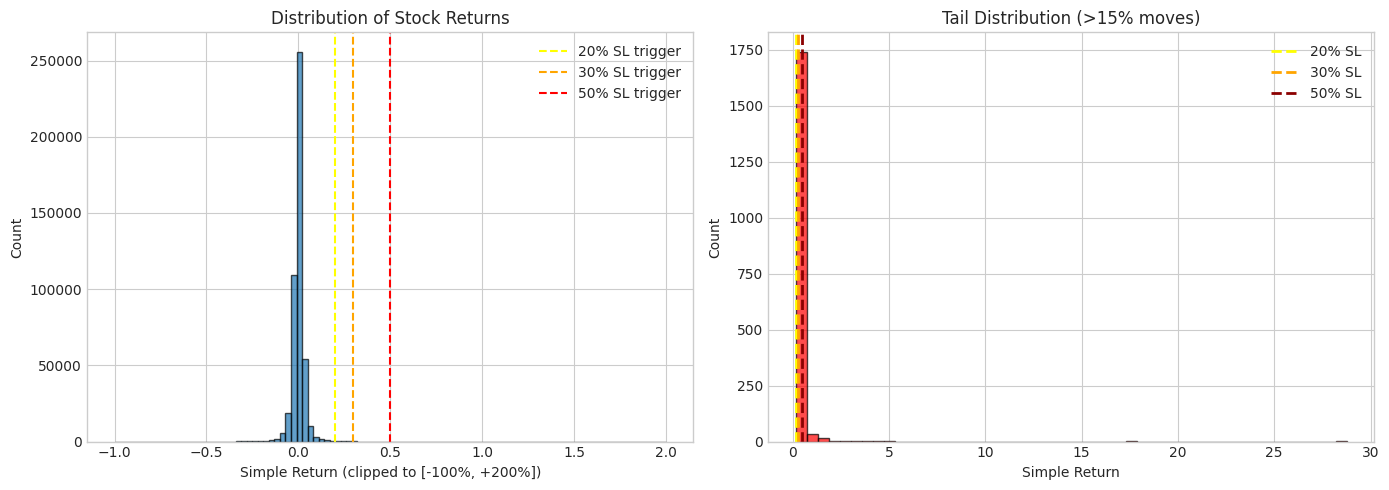

In [17]:
# Histogram of returns
if 'simple_return' in test_df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Full distribution (clipped for visibility)
    ax = axes[0]
    clipped = test_df['simple_return'].clip(-1, 2)
    ax.hist(clipped, bins=100, edgecolor='black', alpha=0.7)
    ax.axvline(0.20, color='yellow', linestyle='--', label='20% SL trigger')
    ax.axvline(0.30, color='orange', linestyle='--', label='30% SL trigger')
    ax.axvline(0.50, color='red', linestyle='--', label='50% SL trigger')
    ax.set_xlabel('Simple Return (clipped to [-100%, +200%])')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Stock Returns')
    ax.legend()
    
    # Tail distribution (>20%)
    ax = axes[1]
    tail = test_df[test_df['simple_return'] > 0.15]['simple_return']
    ax.hist(tail, bins=50, edgecolor='black', alpha=0.7, color='red')
    ax.axvline(0.20, color='yellow', linestyle='--', linewidth=2, label='20% SL')
    ax.axvline(0.30, color='orange', linestyle='--', linewidth=2, label='30% SL')
    ax.axvline(0.50, color='darkred', linestyle='--', linewidth=2, label='50% SL')
    ax.set_xlabel('Simple Return')
    ax.set_ylabel('Count')
    ax.set_title('Tail Distribution (>15% moves)')
    ax.legend()
    
    plt.tight_layout()
    plt.show()

## 3. Stop-Loss Trigger Analysis

How many trades would hit each stop-loss level?

In [18]:
print("STOP-LOSS TRIGGER RATES")
print("(% of all stock-days where SL would trigger if shorted)")
print("=" * 50)

for sl in [0.10, 0.15, 0.20, 0.25, 0.28, 0.30, 0.32, 0.35, 0.40, 0.50]:
    # For shorts, SL triggers when price goes UP
    triggered = (test_df['simple_return'] > sl).sum()
    pct = triggered / len(test_df) * 100
    print(f"  {sl:.0%} SL: {triggered} triggers ({pct:.2f}%)")

print()
print("CUMULATIVE LOSS AVOIDED BY STOP-LOSS:")
print("(Sum of excess returns above SL threshold)")
for sl in [0.20, 0.25, 0.28, 0.30, 0.32, 0.50]:
    # Trades that would hit SL
    triggered_df = test_df[test_df['simple_return'] > sl]
    # Without SL, we'd lose the full amount; with SL we cap at sl
    loss_without_sl = triggered_df['simple_return'].sum()
    loss_with_sl = sl * len(triggered_df)
    saved = loss_without_sl - loss_with_sl
    print(f"  {sl:.0%} SL: Saves {saved:.1%} cumulative ({len(triggered_df)} trades, avg excess {saved/max(len(triggered_df),1):.1%})")

STOP-LOSS TRIGGER RATES
(% of all stock-days where SL would trigger if shorted)
  10% SL: 4193 triggers (0.90%)
  15% SL: 1803 triggers (0.39%)
  20% SL: 937 triggers (0.20%)
  25% SL: 576 triggers (0.12%)
  28% SL: 453 triggers (0.10%)
  30% SL: 371 triggers (0.08%)
  32% SL: 311 triggers (0.07%)
  35% SL: 261 triggers (0.06%)
  40% SL: 194 triggers (0.04%)
  50% SL: 117 triggers (0.03%)

CUMULATIVE LOSS AVOIDED BY STOP-LOSS:
(Sum of excess returns above SL threshold)
  20% SL: Saves 21171.9% cumulative (937 trades, avg excess 22.6%)
  25% SL: Saves 17465.7% cumulative (576 trades, avg excess 30.3%)
  28% SL: Saves 15916.3% cumulative (453 trades, avg excess 35.1%)
  30% SL: Saves 15095.4% cumulative (371 trades, avg excess 40.7%)
  32% SL: Saves 14415.9% cumulative (311 trades, avg excess 46.4%)
  50% SL: Saves 10927.6% cumulative (117 trades, avg excess 93.4%)


## 4. Time-Period Stability

Test if 30% SL works across different sub-periods.

In [ ]:
# Split test period into quarters
from datetime import datetime, timedelta

start = datetime.strptime(START_DATE, '%Y-%m-%d')
end = datetime.strptime(END_DATE, '%Y-%m-%d')
total_days = (end - start).days

# Create ~3 month periods
periods = []
period_days = 90
current = start
while current < end:
    period_end = min(current + timedelta(days=period_days), end)
    periods.append((current.strftime('%Y-%m-%d'), period_end.strftime('%Y-%m-%d')))
    current = period_end + timedelta(days=1)

print(f"Testing across {len(periods)} periods:")
for i, (s, e) in enumerate(periods):
    print(f"  Period {i+1}: {s} to {e}")

In [ ]:
# Test baseline and 30% SL across each period
period_results = []

print("\nTESTING ACROSS TIME PERIODS")
print("=" * 80)

for i, (period_start, period_end) in enumerate(periods):
    print(f"\nPeriod {i+1}: {period_start} to {period_end}")
    
    # Baseline (no SL)
    result_baseline = run_backtest(
        model_path=MODEL_PATH,
        data_dir=DATA_DIR,
        start_date=period_start,
        end_date=period_end,
        initial_cash=INITIAL_CASH,
        use_dd_scaling=False,
        use_confidence=False,
        news_only=True,
    )
    
    # 30% SL
    strategy_cfg = replace(DEFAULT_CONFIG.strategy, stop_loss_pct=0.30)
    config = replace(DEFAULT_CONFIG, strategy=strategy_cfg)
    
    result_sl30 = run_backtest(
        config=config,
        model_path=MODEL_PATH,
        data_dir=DATA_DIR,
        start_date=period_start,
        end_date=period_end,
        initial_cash=INITIAL_CASH,
        use_dd_scaling=False,
        use_confidence=False,
        news_only=True,
    )
    
    print(f"  Baseline: {result_baseline.total_return*100:+.1f}%, Sharpe={result_baseline.sharpe_ratio:.2f}")
    print(f"  30% SL:   {result_sl30.total_return*100:+.1f}%, Sharpe={result_sl30.sharpe_ratio:.2f}")
    
    period_results.append({
        'period': f"P{i+1}",
        'start': period_start,
        'end': period_end,
        'baseline_return': result_baseline.total_return,
        'baseline_sharpe': result_baseline.sharpe_ratio,
        'sl30_return': result_sl30.total_return,
        'sl30_sharpe': result_sl30.sharpe_ratio,
    })

print("=" * 80)

In [20]:
period_df = pd.DataFrame(period_results)
period_df['baseline_pct'] = period_df['baseline_return'] * 100
period_df['sl30_pct'] = period_df['sl30_return'] * 100
period_df['sl30_wins'] = period_df['sl30_return'] > period_df['baseline_return']

print("\nPERIOD COMPARISON:")
print(period_df[['period', 'start', 'end', 'baseline_pct', 'sl30_pct', 'sl30_wins']].to_string(index=False))

print(f"\n30% SL wins in {period_df['sl30_wins'].sum()}/{len(period_df)} periods")


PERIOD COMPARISON:
period      start        end  baseline_pct   sl30_pct  sl30_wins
    P1 2024-10-22 2025-01-20     -5.386579 -48.632045      False

30% SL wins in 0/1 periods


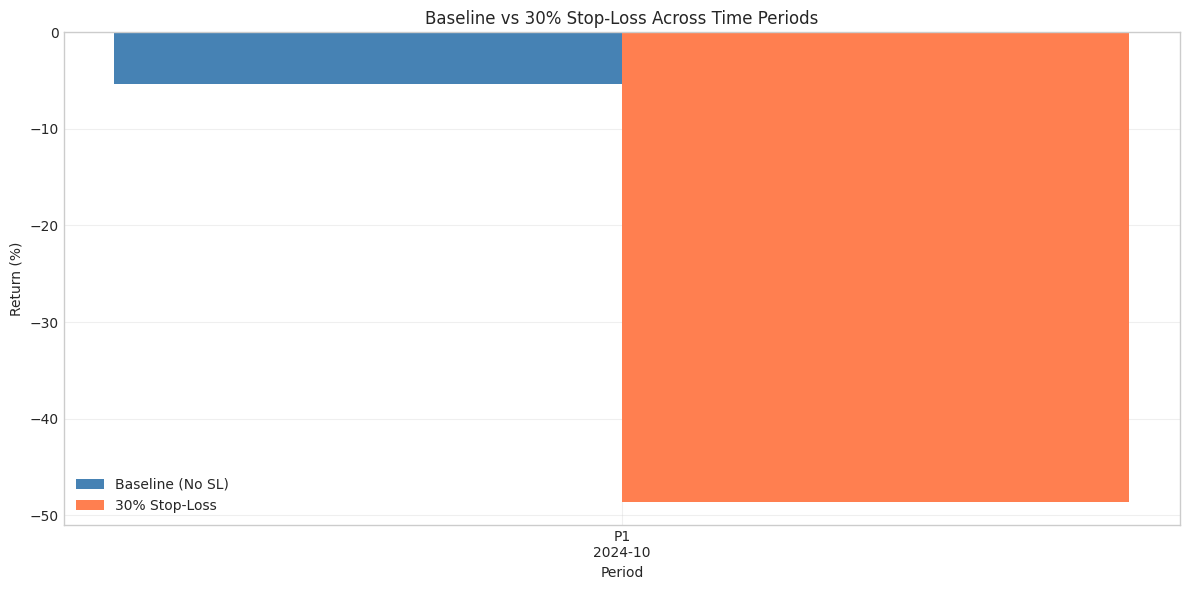

In [21]:
# Visualize period comparison
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(period_df))
width = 0.35

bars1 = ax.bar(x - width/2, period_df['baseline_pct'], width, label='Baseline (No SL)', color='steelblue')
bars2 = ax.bar(x + width/2, period_df['sl30_pct'], width, label='30% Stop-Loss', color='coral')

ax.set_xlabel('Period')
ax.set_ylabel('Return (%)')
ax.set_title('Baseline vs 30% Stop-Loss Across Time Periods')
ax.set_xticks(x)
ax.set_xticklabels([f"{r['period']}\n{r['start'][:7]}" for _, r in period_df.iterrows()])
ax.legend()
ax.axhline(0, color='black', linewidth=0.5)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Outlier Impact Analysis

What happens if we exclude the extreme outliers?

In [22]:
# Find dates with extreme moves
if 'simple_return' in test_df.columns:
    # Group by date, find worst potential short each day
    daily_worst = test_df.groupby('date').agg({
        'simple_return': 'max',  # Worst for shorts
        'symbol': lambda x: x[test_df.loc[x.index, 'simple_return'].idxmax()]
    }).reset_index()
    daily_worst.columns = ['date', 'worst_return', 'worst_symbol']
    
    # Find days with >50% moves
    extreme_days = daily_worst[daily_worst['worst_return'] > 0.50].sort_values('worst_return', ascending=False)
    
    print("DAYS WITH >50% SINGLE-STOCK MOVES")
    print("=" * 60)
    print(extreme_days.head(20).to_string(index=False))
    print(f"\nTotal days with >50% moves: {len(extreme_days)}")

DAYS WITH >50% SINGLE-STOCK MOVES
      date  worst_return worst_symbol
2025-10-31     28.765101         MGNI
2025-09-08     17.367347         QMMM
2025-08-05      5.066007          SMX
2025-03-21      4.551587         MLGO
2025-02-20      4.530435         MLGO
2025-04-03      3.924242         AREB
2024-12-17      3.275253         NUKK
2025-06-13      2.831418          RGC
2025-09-23      2.477306         QURE
2025-02-07      2.067553          CYN
2025-08-11      2.065868         ETHZ
2025-10-13      1.988900         AQMS
2025-10-15      1.837140         PRAX
2025-05-28      1.716392         SBET
2024-12-27      1.670833         HOLO
2025-04-22      1.601961          JYD
2025-12-05      1.472630          WVE
2025-01-02      1.467290         NITO
2025-12-03      1.410668          SMX
2024-11-22      1.384447         QMCO

Total days with >50% moves: 89


In [23]:
# Per-symbol analysis: which symbols have the most extreme moves?
if 'simple_return' in test_df.columns:
    symbol_extremes = test_df.groupby('symbol').agg({
        'simple_return': ['max', 'min', 'mean', 'std', 'count']
    }).round(3)
    symbol_extremes.columns = ['max_return', 'min_return', 'mean_return', 'std_return', 'n_days']
    symbol_extremes = symbol_extremes.reset_index()
    
    # Symbols with biggest upside moves (worst for shorts)
    worst_for_shorts = symbol_extremes.nlargest(15, 'max_return')
    
    print("SYMBOLS WITH BIGGEST UPSIDE MOVES (worst for shorts)")
    print("=" * 70)
    print(worst_for_shorts.to_string(index=False))

SYMBOLS WITH BIGGEST UPSIDE MOVES (worst for shorts)
symbol  max_return  min_return  mean_return  std_return  n_days
  MGNI      28.765      -0.971        0.118       1.866     238
  QMMM      17.367      -0.764        0.372       2.569      46
   SMX       5.066      -0.867        0.030       0.572     108
  MLGO       4.552      -0.311        0.045       0.584     128
  EPSM       4.115      -0.707        0.062       0.659      44
  AREB       3.924      -0.537        0.066       0.725      32
  NUKK       3.275      -0.253        0.026       0.382      81
   RGC       2.831      -0.400        0.057       0.439      56
  QURE       2.477      -0.493        0.012       0.186     205
   CYN       2.068      -0.359       -0.002       0.331      45
  ETHZ       2.066      -0.314       -0.007       0.224     100
  AQMS       1.989      -0.529        0.040       0.404      33
  PRAX       1.837      -0.143        0.012       0.129     238
  SBET       1.716      -0.717        0.007       0

## 6. Monte Carlo: Random Stop-Loss Sensitivity

In [ ]:
# Test many random SL levels to see if 30% is truly special
np.random.seed(42)
random_sl_levels = np.random.uniform(0.15, 0.60, 20)
random_sl_levels = np.sort(random_sl_levels)

random_sl_results = []

print("RANDOM STOP-LOSS LEVELS")
print("=" * 50)

for sl in random_sl_levels:
    strategy_cfg = replace(DEFAULT_CONFIG.strategy, stop_loss_pct=sl)
    config = replace(DEFAULT_CONFIG, strategy=strategy_cfg)
    
    result = run_backtest(
        config=config,
        model_path=MODEL_PATH,
        data_dir=DATA_DIR,
        start_date=START_DATE,
        end_date=END_DATE,
        initial_cash=INITIAL_CASH,
        use_dd_scaling=False,
        use_confidence=False,
        news_only=True,
    )
    
    random_sl_results.append({
        'stop_loss': sl,
        'return': result.total_return,
        'sharpe': result.sharpe_ratio,
    })
    print(f"  SL={sl:.1%}: Return={result.total_return*100:+.1f}%")

random_df = pd.DataFrame(random_sl_results)

In [24]:
# Combine all SL results for visualization
all_sl = pd.concat([
    fine_df[fine_df['stop_loss'].notna()][['stop_loss', 'return', 'sharpe']],
    random_df
]).drop_duplicates('stop_loss').sort_values('stop_loss')

fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(all_sl['stop_loss'] * 100, all_sl['return'] * 100, s=50, alpha=0.7)
ax.axhline(fine_df[fine_df['stop_loss'].isna()]['return'].values[0] * 100, 
           color='red', linestyle='--', label='No Stop-Loss')

# Highlight key points
for sl_val, color, label in [(20, 'orange', '20%'), (30, 'green', '30%'), (50, 'purple', '50%')]:
    point = all_sl[np.abs(all_sl['stop_loss']*100 - sl_val) < 1]
    if len(point) > 0:
        ax.scatter(point['stop_loss']*100, point['return']*100, 
                  s=200, color=color, marker='*', label=f'{label} SL', zorder=5)

ax.set_xlabel('Stop-Loss Level (%)')
ax.set_ylabel('Total Return (%)')
ax.set_title('Return vs Stop-Loss Level (All Tests)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

NameError: name 'random_df' is not defined

## 7. Summary

In [25]:
print("=" * 70)
print("SUMMARY")
print("=" * 70)

# Best and worst SL levels
best_sl = fine_df.loc[fine_df['return'].idxmax()]
worst_sl = fine_df.loc[fine_df['return'].idxmin()]
baseline = fine_df[fine_df['stop_loss'].isna()].iloc[0]

print(f"\nBaseline (no SL):")
print(f"  Return: {baseline['return']*100:+.1f}%")
print(f"  Sharpe: {baseline['sharpe']:.2f}")

print(f"\nBest Stop-Loss ({best_sl['stop_loss_label']}):")
print(f"  Return: {best_sl['return']*100:+.1f}%")
print(f"  Sharpe: {best_sl['sharpe']:.2f}")

print(f"\nWorst Stop-Loss ({worst_sl['stop_loss_label']}):")
print(f"  Return: {worst_sl['return']*100:+.1f}%")
print(f"  Sharpe: {worst_sl['sharpe']:.2f}")

# Period consistency
if len(period_df) > 0:
    wins = period_df['sl30_wins'].sum()
    total = len(period_df)
    print(f"\n30% SL vs Baseline:")
    print(f"  Wins in {wins}/{total} periods ({wins/total*100:.0f}%)")

print("\n" + "=" * 70)

SUMMARY

Baseline (no SL):
  Return: +65.9%
  Sharpe: 0.65

Best Stop-Loss (None):
  Return: +65.9%
  Sharpe: 0.65

Worst Stop-Loss (15%):
  Return: -86.0%
  Sharpe: -10.58

30% SL vs Baseline:
  Wins in 0/1 periods (0%)

